In [31]:
import warnings
import copy
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans,DBSCAN
from sklearn import metrics
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples,silhouette_score
from sklearn.decomposition import PCA
warnings.filterwarnings("ignore") #忽略告警信息

In [32]:
def data_desc(df_table):
    t = []
    n = df_table.shape[0]
    for vals in df_table.columns.values.tolist():
        n_dtype = df_table[vals].dtype  #变量类型
        #         n=df_table[vals].count() #变量个数
        n_distinct = df_table[vals].drop_duplicates().count()  #变量去重个数
        n_miss = sum(pd.isnull(df_table[vals]))  #缺失值个数
        pct_miss = np.round(n_miss * 100 / n, 2)  #缺失比例

        if df_table[vals].dtype != 'object':
            n_min = df_table[vals].min()  #最小值
            n_max = df_table[vals].max()  #最大值
            n_mean = df_table[vals].mean()
            n_std = df_table[vals].std()
            q = stats.scoreatpercentile(df_table[vals].dropna(),
                                        [5, 25, 50, 75, 99.9])  #分位数
        else:
            n_min = np.nan
            n_max = np.nan
            n_mean = np.nan
            n_std = np.nan
            q = [np.nan, np.nan, np.nan, np.nan, np.nan]
        q_low = q[1] - 3 * (q[3] - q[1])  #75分位数-25分位数（异常值下界）
        q_upper = q[3] + 3 * (q[3] - q[1])  #75分位数-25分位数（异常值上界）
        t.append(
            (vals, n_dtype, n, n_distinct, n_miss, pct_miss, n_min, n_max,
             n_mean,n_std,q[0], q[1], q[2], q[3], q[4],
             (df_table[vals] < q_low).sum() + (df_table[vals] > q_upper).sum(),
             df_table.loc[(df_table[vals] > q_upper) |
                          (df_table[vals] < q_low)].index.tolist()[0:3]))
    colnums = [
        'colums', 'n_dtype', 'n_num', 'n_distinct', 'n_miss', 'pct_miss',
        'n_min', 'n_max', 'n_mean','n_std', 'q_5', 'q_25', 'q_50', 'q_75', 'q_99',
        'n_outliers', 'outliers_index'
    ]
    df_table1 = pd.DataFrame(t, columns=colnums)
    return df_table1


In [3]:
paths='./file/用户分群.txt'
data = pd.read_csv(paths, encoding='gbk')
pd.set_option('display.max_columns', 100)  ##设置显示列数
pd.set_option('precision', 4)  ##设置小数点位数

In [35]:
var_name=['age','all_write_cnt','zhaopian_num','shiping_num','shuoshuo_cnt','rizhi_cnt','fenxiang_cnt','liuyan_cnt','songli_cnt','dianzan_cnt','pinglun_cnt']
data_tmp1=data.loc[data['all_write_days']>0,var_name]
###缺失值填补
data_tmp1.loc[data_tmp1['age'].isnull(),'age']=data_tmp1.loc[data_tmp1['age'].isnull(),'age'].fillna(-1)
# data_tmp1.loc[data_tmp1['qq_age'].isnull(),'qq_age']=data_tmp1.loc[data_tmp1['qq_age'].isnull(),'qq_age'].fillna(-1)

In [37]:
from collections import Counter
def detect_outliers(df,n,features): #筛选异常值
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices=[]
    for col in features:
        Q1=np.percentile(df[col], 25)
        Q3=np.percentile(df[col],75)
        outlier_step=3*(Q3 - Q1)
        outlier_list_col=df[df[col]>Q3+outlier_step].index
#         outlier_list_col=df[(df[col]<Q1-outlier_step)|(df[col]>Q3+outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices=Counter(outlier_indices)        
    multiple_outliers=list(k for k,v in outlier_indices.items() if v>n)
    return multiple_outliers   

Outliers_to_drop=detect_outliers(data_tmp1,4,data_tmp1.columns.tolist()[2:])
# 'all_write_cnt','zhaopian_num','shiping_num'
data_tmp1=data_tmp1.drop(Outliers_to_drop,axis=0).reset_index(drop=True)

In [38]:
####将超过99分位的原始数据人工修改为99分位
for var_name in data_tmp1.columns.tolist()[1:]:
    p_99=np.percentile(data_tmp1[var_name], 99.9)
    data_tmp1[var_name]=data_tmp1[var_name].apply(lambda x:p_99 if x>p_99 else x)

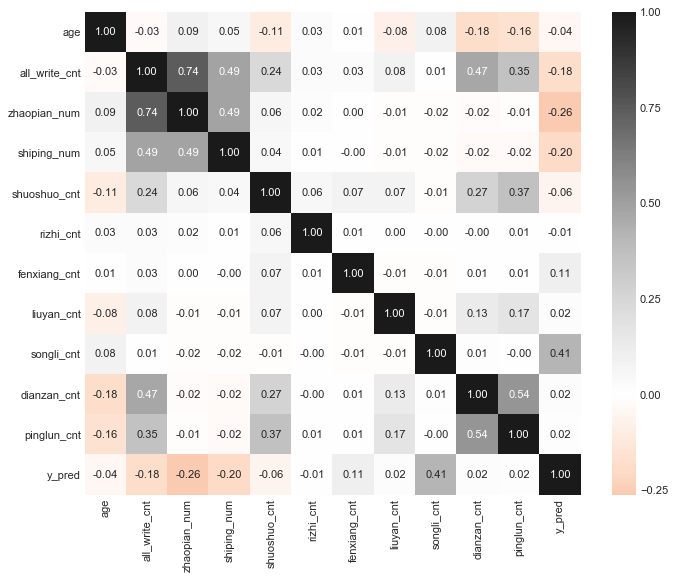

In [55]:
#相关性检验
plt.figure(figsize=(10, 8), dpi=80, edgecolor='k').add_subplot(1,1,1)
sns.heatmap(data_tmp1.corr(),annot=True,cbar=True,cmap='RdGy',fmt = ".2f",center=0)

In [43]:
#计算tf_idf值，对热门功能进行惩戒
data_tmp2=copy.deepcopy(data_tmp1)
def tf_idf(var):
    tf=data_tmp2[var]/data_tmp2['all_write_cnt']
    idf=np.log(data_tmp2.shape[0]/data_tmp2[data_tmp2[var]>0].shape[0])
    return tf*idf

for var in data_tmp2.columns.tolist()[2:]:
    data_tmp2['pct_%s'%var]=tf_idf(var)
    data_tmp2.drop('%s'%var,inplace=True,axis=1) #删除部分变量
data_tmp2.drop('all_write_cnt',inplace=True,axis=1) #删除部分变量

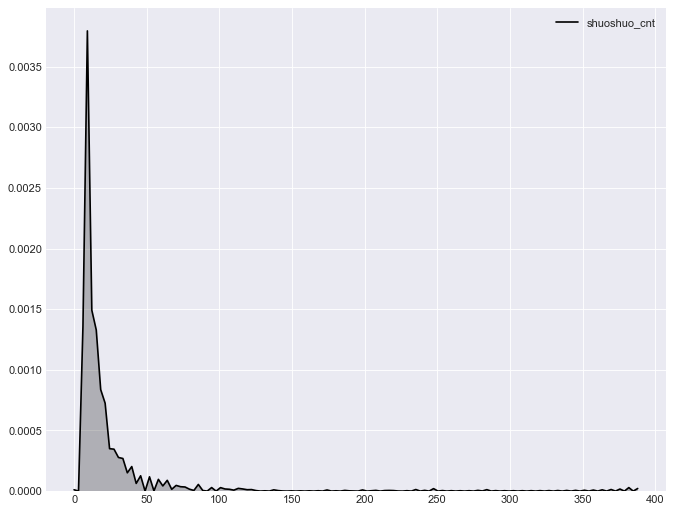

In [36]:
##部分变量存在幂指分布
fig = plt.figure(figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')
sns.set_style('darkgrid')
# sns.distplot(data_tmp1['zhaopian_num'])
sns.kdeplot(data_tmp1['shuoshuo_cnt'],color='black',shade=True,)
# sns.kdeplot(data_tmp2['pct_shuoshuo_cnt'],color='black',shade=True,)

In [44]:
#对部分幂指分布的用户进行log线性处理
for var in data_tmp2.columns.tolist():
    data_tmp2['%s_log'%var]=data_tmp2['%s'%var].map(lambda i:np.log10(i+2)) 
    data_tmp2.drop('%s'%var,inplace=True,axis=1) #删除部分变量
######数据标准化
data_tmp2=pd.DataFrame(preprocessing.scale(data_tmp2),columns=data_tmp2.columns)

In [80]:
####降维
pca=PCA(n_components=3)
data_tmp3=pca.fit_transform(data_tmp2)

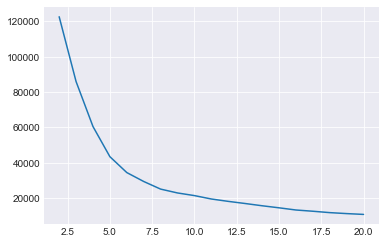

In [47]:
#####SSE选择K的取值
distortions=[]
for i in np.linspace(2,20,19).astype(int):
    y_pred=KMeans(n_clusters=i, n_jobs = 4,random_state=9).fit(data_tmp3)
    distortions.append(y_pred.inertia_)
plt.plot(np.linspace(2,20,19).astype(int),distortions)

In [52]:
###轮廓系数
distortions=[]
for i in np.linspace(2,10,9).astype(int):
    y_pred=KMeans(n_clusters=i,n_jobs = 4).fit_predict(data_tmp3)
    distortions.append(silhouette_score(data_tmp3, y_pred))
plt.plot(np.linspace(2,10,9).astype(int),distortions)    

In [53]:
def kmeans(data,k):
    def _distance(p1,p2): #计算点之间的距离
        tmp = np.sum((p1-p2)**2)
        return np.sqrt(tmp)

    def _rand_center(data,k): #给定随机k个质心
        n = data.shape[1] # features
        centroids = np.zeros((k,n)) # init with (0,0)....
        for i in range(n):
            dmin, dmax = np.min(data[:,i]), np.max(data[:,i])
            centroids[:,i] = dmin + (dmax - dmin) * np.random.rand(k)
        return centroids
    
    def _converged(centroids1, centroids2):
        
        # if centroids not changed, we say 'converged'
        set1 = set([tuple(c) for c in centroids1])
        set2 = set([tuple(c) for c in centroids2])
        return (set1 == set2)
        
    
    n = data.shape[0] # number of entries
    centroids = _rand_center(data,k)
    label = np.zeros(n,dtype=np.int) # track the nearest centroid
    assement = np.zeros(n) # for the assement of our model
    converged = False
    
    while not converged:
        old_centroids = np.copy(centroids)
        for i in range(n):
            # determine the nearest centroid and track it with label
            min_dist, min_index = np.inf, -1
            for j in range(k):
                dist = _distance(data[i],centroids[j])
                if dist < min_dist:
                    min_dist, min_index = dist, j
                    label[i] = j
            assement[i] = _distance(data[i],centroids[label[i]])**2
        
        # update centroid
        for m in range(k):
            centroids[m] = np.mean(data[label==m],axis=0)
        converged = _converged(old_centroids,centroids)    
    return centroids, label, np.sum(assement)

In [ ]:
best_assement = np.inf
best_centroids = None
best_label = None

for i in range(10):
    centroids, label, assement = kmeans(data_tmp3,2)
    if assement < best_assement:
        best_assement = assement
        best_centroids = centroids
        best_label = label

data0 = data_tmp3[best_label==0]
data1 = data_tmp3[best_label==1]

In [81]:
data_tmp1['y_pred']=KMeans(n_clusters=6, n_jobs = 4,random_state=9).fit_predict(data_tmp3)
data_tmp2['y_pred']=data_tmp1['y_pred']
print(np.bincount(data_tmp1['y_pred'])*100/data_tmp1.shape[0])
data_tmp1.groupby(['y_pred']).mean().reset_index()

[ 6.37850621 25.9913727  27.92922989  5.90553767 29.59118877  4.20416475]


,y_pred,age,all_write_cnt,zhaopian_num,shiping_num,shuoshuo_cnt,rizhi_cnt,fenxiang_cnt,liuyan_cnt,songli_cnt,dianzan_cnt,pinglun_cnt
0,0,36.5201,11.2396,0.2142,0.0161,0.0240,0.0021,0.0457,0.0034,6.7438,0.7961,0.1679
1,1,34.5419,139.6345,105.8330,10.0152,0.5801,0.0111,0.0919,0.0083,0.1988,1.2495,0.2815
2,2,26.1202,53.5242,1.4092,0.0350,0.6638,0.0016,0.0651,0.0789,0.1354,37.0967,3.5802
3,3,32.5221,4.5762,0.1357,0.0048,0.0438,0.0178,2.1309,0.1042,0.0230,0.2429,1.1487
4,4,31.7124,40.1248,3.7876,0.1821,0.5679,0.0191,0.1864,0.0660,0.2989,3.5227,1.5121
5,5,27.5844,18.4312,7.8750,0.7927,4.2625,0.0245,0.2526,0.0229,0.0177,0.9406,0.7146


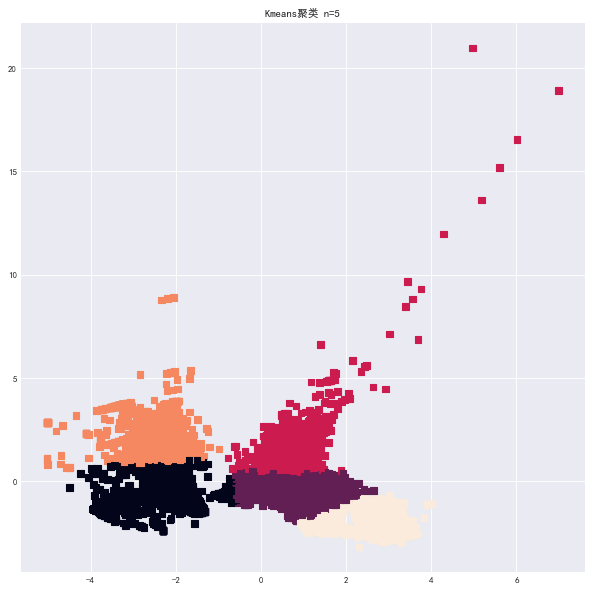

In [79]:
L1=[n[0] for n in data_tmp3]
L2=[n[1] for n in data_tmp3]

#用来正常显示负号
plt.rcParams['axes.unicode_minus']=False 
plt.rc('font', family='SimHei', size=8)
fig = plt.figure(figsize=(20,20), dpi=80, facecolor='w', edgecolor='k')
p1 = plt.subplot(221)
plt.title(u"Kmeans聚类 n=5")
plt.scatter(L1,L2,c=data_tmp1['y_pred'],marker="s")
plt.sca(p1)

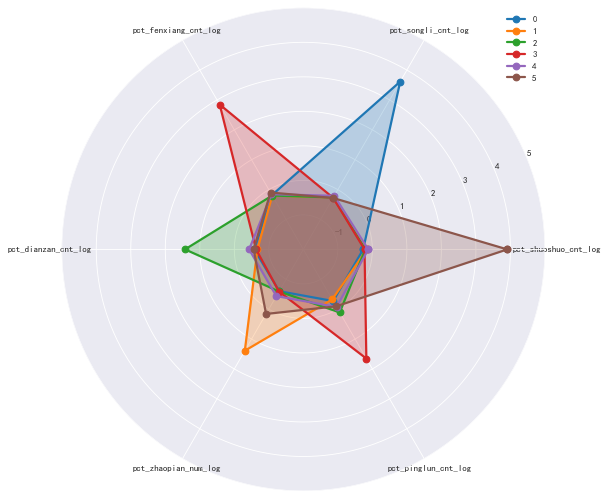

In [82]:
data_tmp1_gb=data_tmp2.groupby(['y_pred']).mean().reset_index()
data_tmp1_gb_nm=data_desc(data_tmp1_gb.iloc[:,1:]).sort_values(['n_std'],ascending=False).iloc[0:6,:]['colums'].tolist()
data_tmp1_gb=data_tmp1_gb[['y_pred']+data_tmp1_gb_nm]

values_tmp1,angles_tmp1,cluster_result=[],[],np.unique(data_tmp1['y_pred'])
for i in cluster_result:
    feature=data_tmp1_gb.columns.tolist()[1:]
    values = np.array(data_tmp1_gb[data_tmp1_gb['y_pred']==i].iloc[:,1:]).tolist()[0]
    angles=np.linspace(0, 2*np.pi, len(values), endpoint=False)
    values_tmp1.append(np.concatenate((values,[values[0]])))
    angles_tmp1.append(np.concatenate((angles,[angles[0]])))

ax=plt.figure(figsize=(10, 8), dpi=80, edgecolor='k').add_subplot(111,polar=True)
for i in cluster_result:
    ax.plot(angles_tmp1[i], values_tmp1[i], 'o-', linewidth=2, label = i) # 绘制折线图
    ax.fill(angles_tmp1[i], values_tmp1[i], alpha=0.25) # 填充颜色
    ax.set_thetagrids(angles_tmp1[i] * 180/np.pi, feature) # 添加每个特征的标签
ax.set_ylim(-2,5) # 设置雷达图的范围
ax.grid(True) # 添加网格线
plt.legend(loc = 'best') # 设置图例
plt.show() # 显示图形
